# ExplainableRL: Onboarding recipe
Pricing strategy can hugely influence a company's profitability, and therefore understanding price sensitivity and market demand is essential. With ExplainableRL, we have automated the manual process of pricing strategies using reinforcement learning. We have overcome the limitations of popular RL libraries such as Mushroom RL by creating an environment capable of dealing with industry datasets, and an explainability framework to understand the automated decisions.

This notebook presents a comprehensive guide on utilizing ExplainableRL. It outlines the necessary steps, including the selection of environment, training of preferred agent, performance evaluation, generation of PDP plots and SHAP values to aid in understanding the agent's decision-making, and an overview of the time and memory performance of the primary processing components of the library. A more detailed overview of ExplainableRL can be found in the documentation.


### Relevant imports
The file library.py contains all the necessary packages for this notebook. It can be found in the root directory of the repository.
The classes and functions used in this notebook are imported from the src folder.

In [1]:
from library import *

# Import functions
from src.foundation.engine import Engine
from src.data_handler.data_handler import DataHandler
from src.explainability.pdp import PDP
from src.explainability.shap_values import ShapValues
from src.evaluation.evaluator import Evaluator
from src.foundation import utils
from src.performance.performance_evaluator import PerformanceEvaluator

### 1. Parameters Setting

#### 1.1. Parameters Setting: Overview
There are six components that need to be configured to use ExplainableRL. Expand this tab to access a detailed explanation of each parameter.

##### Dimensions:
- States (states): columns from dataset to use as features, and the number of bins to divide them into.

- Actions (actions): column from dataset to use as action, and the number of bins to divide it into.

- Rewards (rewards): column from dataset to use as rewards, and the number of bins to divide it into.

##### Dataset:
- Data Path (data_path): Path to dataset.

- Columns Delimeter (col_delimiter): Delimeter used to separate the columns in dataset.

- Number of Samples (n_samples): Number of samples to use from dataset.

- Normalisation Flag (normalisation): Whether to normalise the dataset.

##### Training:
- Environment Type (env_type): which environment to use. Options = {'strategic_pricing_prediction', 'strategic_pricing_suggestion'}.

- Number of Episodes (num_episodes): Number of episodes to use for training.

- Number of Steps (num_steps): Maximum number of steps for each episode.

- Train/Test Splitting (train_test_split): Ratio for splitting train and test data.

- Evaluation Flag (evaluate): Flag to specify whether to evaluate the agent or not.

- Number of Evaluation Steps (num_eval_steps): Intervals at which to evaluate the agent (on test set) during training.

##### Agent:
- Agent Type (agent_type): Which agent to use. Options: {'q_learner', 'double_q_learner', 'sarsa', 'sarsa_lambda'}.

- Gamma (gamma): Discount factor.

- Epsilon (epsilon): Exploration parameter.

- Epsilon Decay (epsilon_decay): By how much to decay epsilon.

- Epsilon Minimum (epsilon_minimum): The minimum value epsilon can reach.

- Learning Rate (learning_rate): Learning rate for training.

- Learning Rate Decay (learning_rate_decay): Rate at which to decay the leaning rate.

- Minumum Learning Rate Decay (learning_rate_decay_minimum): The minimum value the learning rate can reach.

- Lambda (lambda): Amount by which the agent will look into the past (Only needed for Sarsa(Lambda) agent).

- Uncertainty Flag (use_uncertainty): Flag to specify whether to use uncertainty-informed ('True') or the epsilon-greedy policy ('False').

- Importance of q values (q_importance): Weight given to q values when computing the optimal action using the uncertainty-informed policy.

##### Explainability:
- Number of SHAP samples (shap_num_samples): Number of samples on which the SHAP values are computed.

##### Program Flow:
- Verbose Flag (verbose): Whether to print status/information statements throughout the program overflow.

#### 1.2. Parameter Setting: Configuration

In [2]:
hyperparam_dict_ds_data_predict = {
    "dimensions": {'states': {'lead_time': 10,
                                'length_of_stay': 10,
                                'competitor_price_difference_bin': 4,
                                'demand_bin': 4},
                    'actions': {'price': 10},
                    'rewards': ['reward']
                    },

    "dataset": {'data_path': 'data/ds-data/my_example_data.parquet',
                'col_delimiter': '|',
                'n_samples': 100000,
                'normalisation': True},

    "training": {'env_type': 'strategic_pricing_predict',
                    'num_episodes': 50000,
                    'num_steps': 1,
                    'train_test_split': 0.2,
                    'evaluate': False,
                    'num_eval_steps': 10000},

    "agent": {'agent_type': 'double_q_learner',
                "gamma": 0.3,
                "epsilon": 0.1,
                "epsilon_decay": 0.05,
                "epsilon_minimum": 0.01,
                "learning_rate": 0.1,
                "learning_rate_decay": 0.05,
                "learning_rate_minimum": 0.01,
                "lambda": 0.2,
                "use_uncertainty": False,
                "q_importance": 0.7,
                },

    "explainability": {'shap_num_samples': 1},

    "program_flow": {"verbose": False}
}

### 2. Initialisation

The hyper parameters disctionary is used to initialise the whole process.
`hyperparam_dict` variable name is used as is the default name in the repository.

In [3]:
hyperparam_dict = hyperparam_dict_ds_data_predict

#### 2.a. Data Loading
The dataset is not loaded inside the ``DataHandler`` so that the user is able to inspect and analyse the data before using it. Please note that the reward needs to be explicitly defined. For example for a pricing dataset for an online drug retailer, the reward might be the revenue generated from an online session, and not simply whether the user made a purchase decision. We suggest adding a 'reward' column to the data so that it is explicitly defined.

Load the dataset:

In [4]:
dataset = utils.load_data(data_path=hyperparam_dict['dataset']['data_path'],
                          n_samples=hyperparam_dict['dataset']['n_samples'],
                          delimiter=hyperparam_dict['dataset']['col_delimiter'])

Train the dataset in train and test set for evaluation purposes:

In [5]:
train_dataset, test_dataset = utils.split_train_test(dataset)

#### 2.b. Datahandler Initialisation

For simplicity, we have included a ``DataHandler`` in our repo that takes care of the main operations done with any dataset.

It takes as input a training and test dataset, which should be in Pandas DataFrame format (see above for an example of how to load it). The data can be un-normalised, and if it is normalised then it must be normalised to the range [0,1]. Please indicate whether it should be normalised through the hyperparameter dictionary, defined above, which it also takes as input. NB True means normalisation will occur.

The DataHandler performs various operations through the ``Engine`` class (i.e. a user only needs to load the data into the DataHandler and the ``Engine`` will call the rest of the functions). The main method is to normalise the dataset (if normalisation set to True), which also drops any rows in the data with null values.

At any point during the use of the codebase, the ``DataHandler`` can also perform other operations:
- Un-normalise the dataset.
- Get the state columns of the dataset.
- Get the action columns of the dataset.
- Get the reward columns of the dataset.
- Get the action labels of the dataset.

In [6]:
dh = DataHandler(hyperparam_dict=hyperparam_dict, dataset=train_dataset, test_dataset=test_dataset)

#### 2.b. Engine Initialisation
The ``Engine`` class handles all interactions between the agent, environment and dataset. Training, evaluating and saving agents should be done through the Engine. 

The ``Engine`` takes a ``DataHandler`` (initialised with the relevant datasets) and the hyperparameter dictionary as input. It has a few public facing methods:
- create_world() - explained below
- create_agent() - creates an agent according to the definition in the hyperparameters dictionary.
- create_env() - creates an environment according to the specification in the hyperparameters dictionary.
- train_agent() - trains the agent (explained below).

In [7]:
engine = Engine(dh=dh, hyperparam_dict=hyperparam_dict)

#### 2.c. Environment and Agent Initialisation
The ``engine.create_world`` method creates both the environment and the agent
by way of the ``engine.create_env`` and ``engine.create_agent`` respectively.

#### 1) Environment
The ``create.env`` method creates an environment instance and stores it as 
an attribute in the engine. This is accomplished by constructing a table of
state-action pairs and associated average rewards. These are obtained from the
inputted dataset.

There are several environments available in our library. These can be selected by
altering the value of the hyperparameter key: ``[training][env_type]``. See 
Parameters Setting: Overview section for further information.

##### 1.1) Prediction Environment
The strategic pricing **prediction** environment addresses the following problem:
given a set of state dimensions (e.g. ad flag, competitor price, ...), predict 
the optimal price. In this case, 'optimal' refers to the price that maximises
revenue. This is a single-step RL environment in that every next state 
is also a terminal state.

##### 1.2) Suggestion Environment
The strategic pricing **suggestion** environment addresses the following problem:
given a set of state dimensions (e.g. ad flag, competitor price, ...) which must
include the price (as opposed to the prediction environment), suggest the optimal
price to move to. As previously, 'optimal' refers to the price that maximises
revenue. This is a multi-step RL environment in that some states have a next state
and others are terminal.

#### 2) Agent
The ``create.agent`` method creates an agent instance and stores it as an attribute
in the engine. In practice, this instance is an RL agent which has the common 
``fit``, ``policy``, and ``predict`` methods. The ``step`` method will depend on
the type of agent that is selected.

So far, this library supports the following agents/algorithms:
- Q-Learner
- Double Q-Learner
- Sarsa
- Sarsa($\lambda$)

A specific agent can be selected by altering the value of the hyperparameter key: ``[agent][agent_type]``.

In [8]:
engine.create_world()

### 3. Agent Training and Saving

#### 3.a. Training
The ``engine.train_agent`` method trains an agent for a specified number of steps and episodes. This is done by running the ``engine.agent.fit`` method.

All agent types inherit from a Temporal-Difference (TD) super-agent, and therefore adopt the same training structure.

In [9]:
engine.train_agent()

100%|██████████| 50000/50000 [12:22<00:00, 67.31it/s]  


#### 3.b. Saving
To avoid redundant training, the engine, which contains the trained agent object as an attribute, can be saved as a pickle file.

In [10]:
# TODO: Explain that the training set is removed from the dh
utils.save_engine(engine, 'runs/double_q_learner_GS.pkl')

#### 3.c. Loading
To load the engine, use the ``utils.load_engine`` function that will unpickle the saved engine object. It accepts as input either one single path or a list of paths.

In [11]:
engine = utils.load_engine('runs/double_q_learner_GS.pkl')

### 4. Agent Evaluation

We have included an `Evaluator` class which provides custom Reinforcement Learning metrics to evaluate the agents that were trained in the previous parts. It also includes statistical plots that allow to compare different agent types with the historical baseline.

It takes as input a list of trained engines, and it evaluates the total reward collected on the test dataset by applying the agent's learned policy and the historical baseline (i.e., the actions which appear in the dataset).

#### 4.a. Load Agents to Evaluate

In [3]:
engines = utils.load_engine([
    'runs/q_learner_1.pkl',
    'runs/q_learner_2.pkl'])

#### 4.b Initialize Evaluator

In [4]:
evaluator = Evaluator(engines = engines)

#### 4.c Total reward metrics
The `hist_cum_rewards()` and `agent_cum_rewards()` methods calculate the total historical cumulative reward on the evaluation set, and the total agent cumulative reward on the evaluation set, i.e., the reward collected using the agent's policy.

In [5]:
print(f"Historical baseline: {evaluator.hist_cum_rewards()}")
print(f"Agent Policy: {evaluator.agent_cum_rewards()}")

Historical baseline: [143023.50956064934, 146593.87606288586]
Agent Policy: [134261.0306639864, 176121.9621258187]


#### 4.d Plot cumulative reward versus episode
The `evaluator.plot_training_curve()` method plots the cumulative reward on the test set versus episode number. In case you provided several saved engines corresponding to different agent types, it will automatically plot the mean and standard deviation of every agent type. This plot can only be produced if the flag hyperparam_dict['training']['evaluate'] was set to True during training.

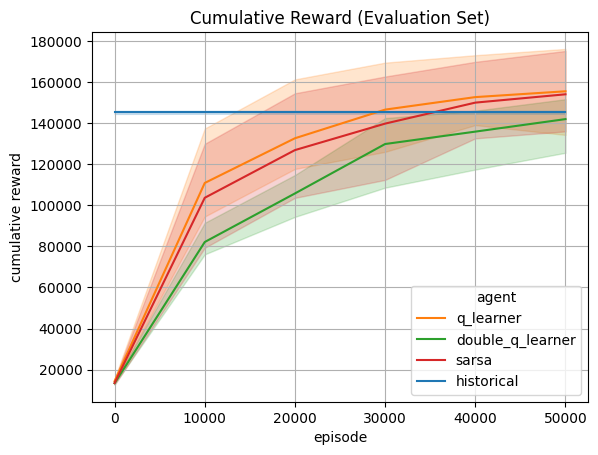

In [52]:
evaluator.plot_training_curve()

#### 4.e Plot average reward distribution

The `plot_reward_distribution()` method plots the average reward percentiles. For example, the 90-th percentile corresponds the reward value such that 90% of the agent rewards in the test set are under such value.

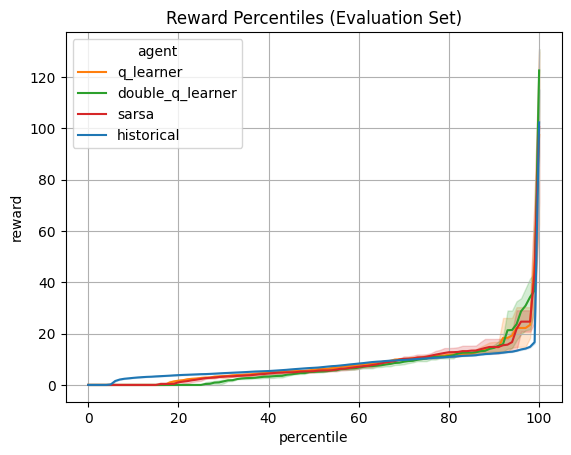

In [53]:
evaluator.plot_reward_distribution()

### 5. Explainability

In the explainability part of the repository, two main methods to explain what the agent has learnt are implemented. 
Both methods require the saved engine containing the trained agent, hence they can be used not only at training time but anytime explainability results are required.

The methods are the PDP plots and the SHAP values. The usages of the methods are detailed in the sections below.

#### 5.a. PDPs

The PDPs (Partial Dependence Plots) are used to understand the relationship between the suggested action and the state dimensions for each state dimension bin. These plots can be used to intepret what the agent learnt.
In particulat, a PDP plot shows the average predicted action for a specific state dimension bin, keeping all the other state dimensions constant. Hence, it shows the marginal effect of the state dimensions.

The class `PDP` prepare the data to build the PDP plots and build the plots.

The class is firstly initialised using the engine containg the agent we want to explain.

In [12]:
pdp = PDP(engine=engine)
pdp.build_data_for_plots()

The user can choose whether to save the plot and with what name.

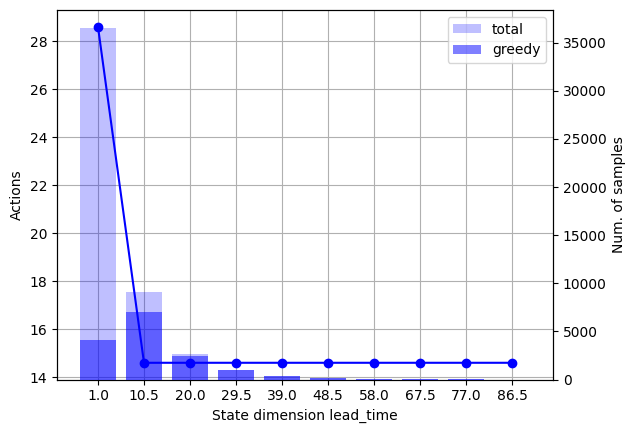

In [13]:
fig_name = "PDP plots - lead_time"
pdp.plot_pdp(feature="lead_time", fig_name=fig_name, savefig=True)

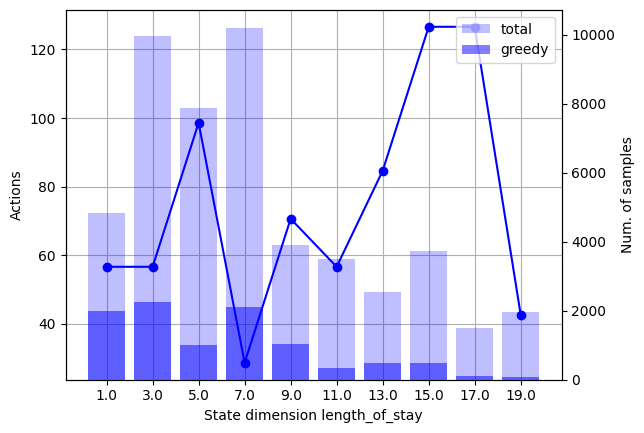

In [14]:
fig_name = "PDP plots - length_of_stay"
pdp.plot_pdp(feature="length_of_stay", fig_name=fig_name, savefig=True)

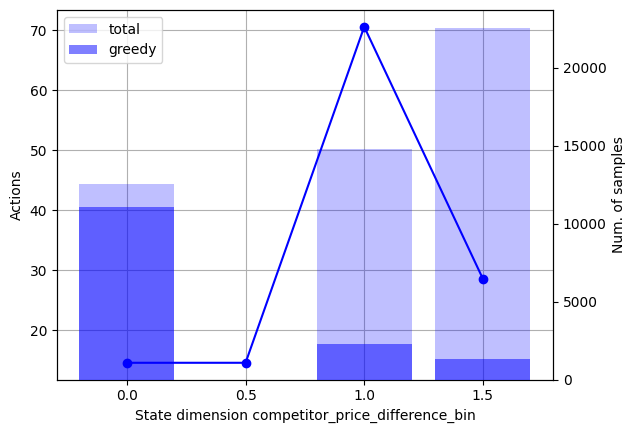

In [15]:
fig_name = "PDP plots - competitor_price_difference_bin"
pdp.plot_pdp(feature="competitor_price_difference_bin", fig_name=fig_name, savefig=True)

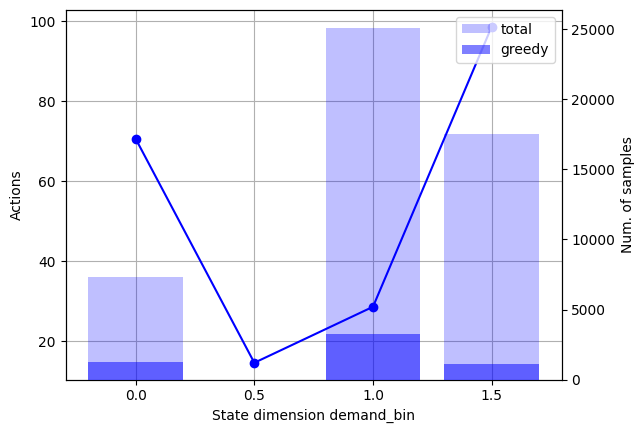

In [16]:
fig_name = "PDP plots - demand_bin"
pdp.plot_pdp(feature="demand_bin", fig_name=fig_name, savefig=True)

#### 5.b. Shap Values
SHAP (SHapley Additive exPlanations) values is a technique used to explain how the state dimensions impact the action predicted by the agent for a specific sample.

The class `ShapValues` prepares the data to compute the SHAP values for a specific sample and computes them.

Firstly, the class is initialised.

In [23]:
engine.hyperparameters['explainability']["shap_num_samples"] = 500

In [24]:
shap_values = ShapValues(engine=engine)

Then, the SHAP values for a given sample are computed. The predicted action for the sample is returned as well to allow a better intepretation of the SHAP values.

In [25]:
shaps, predicted_action = shap_values.compute_shap_values(sample=[8, 1, 1, 1])

In [26]:
print("Shap values: ", shaps)
print("Predicted action: ", predicted_action)

Shap values:  {'lead_time': 7.448, 'length_of_stay': -7.84, 'competitor_price_difference_bin': 2.968, 'demand_bin': -2.1}
Predicted action:  14.6


The SHAP values can also be visualised using a bar plot.

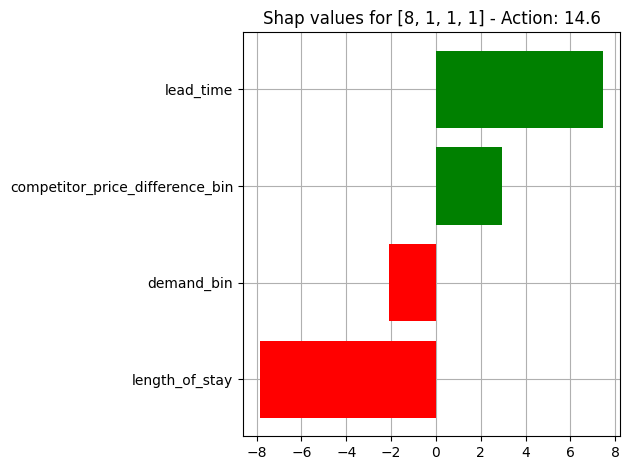

In [28]:
shap_values.plot_shap_values(sample=[8, 1, 1, 1], shap_values=shaps, predicted_action=predicted_action,
                             fig_name="SHAP values", savefig=False)

### 6. Performance

The time and space complexity of loading the data and training the agent can be easily obtained by instantiating a PerformanceEvaluator object and calling its methods as shown below.

The results are by default stored in the src/performance/evaluations/ folder. The user can pass in the desired path (as the kwarg results_path) to the PerformanceEvaluator constructor.

The user can also pass in the ranges of sample number, episode number, and bin number to be ranged over during performance evaluator. All these args can be omitted and will take the default values in the constructor's signature.

The benchmark settings can be edited in the constructor.

In [2]:
# User-defined parameters
results_path = "performance-evaluations"
num_sample_range=[int(1e2), int(1e3), int(1e4), int(1e5), int(1e6)]
num_ep_range = [int(1e1), int(1e2), int(1e3), int(1e5)]
num_bin_range=[10, 20, 50, 100]

In [3]:
# Instantiate PerformanceEvaluator
performance_evaluator = PerformanceEvaluator(results_path="performance-evaluations",
                                             num_sample_range=num_sample_range,
                                             num_ep_range=num_ep_range,
                                             num_bin_range=num_bin_range,
                                             verbose=True)


GETTING BENCHMARK PERFORMANCE
-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 671.23it/s]



GETTING PERFORMANCE GRAPHS
* Plot of performance vs number of samples
-> Running training loop for 10 episodes, 10 bins, 100 samples


100%|██████████| 10/10 [00:00<00:00, 721.96it/s]


-> Running training loop for 10 episodes, 10 bins, 1000 samples


100%|██████████| 10/10 [00:00<00:00, 756.14it/s]


-> Running training loop for 10 episodes, 10 bins, 10000 samples


100%|██████████| 10/10 [00:00<00:00, 689.08it/s]


-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 726.63it/s]


-> Running training loop for 10 episodes, 10 bins, 1000000 samples


100%|██████████| 10/10 [00:00<00:00, 757.93it/s]


* Plot of performance vs number of episodes
-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 767.04it/s]


-> Running training loop for 100 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 766.64it/s]


-> Running training loop for 1000 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 685.55it/s]


-> Running training loop for 100000 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 785.44it/s]


* Plot of performance vs number of bins
-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 707.22it/s]


-> Running training loop for 10 episodes, 20 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 765.69it/s]


-> Running training loop for 10 episodes, 50 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 770.18it/s]


-> Running training loop for 10 episodes, 100 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 708.07it/s]



GETTING TIME BREAKDOWN PER FUNCTION
-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 560.38it/s]



GETTING SPACE BREAKDOWN PER FUNCTION
-> Running training loop for 10 episodes, 10 bins, 100000 samples


100%|██████████| 10/10 [00:00<00:00, 759.77it/s]


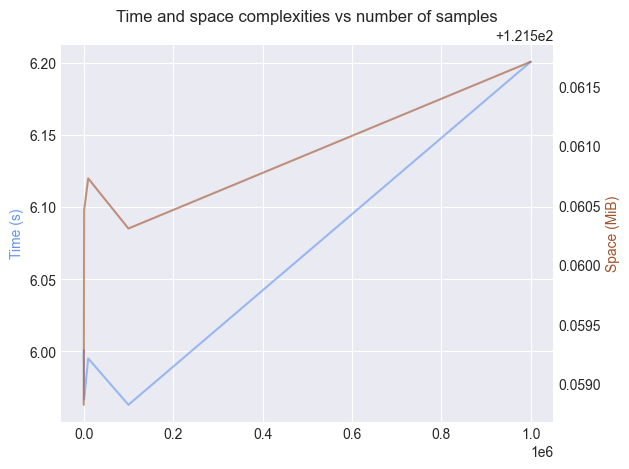

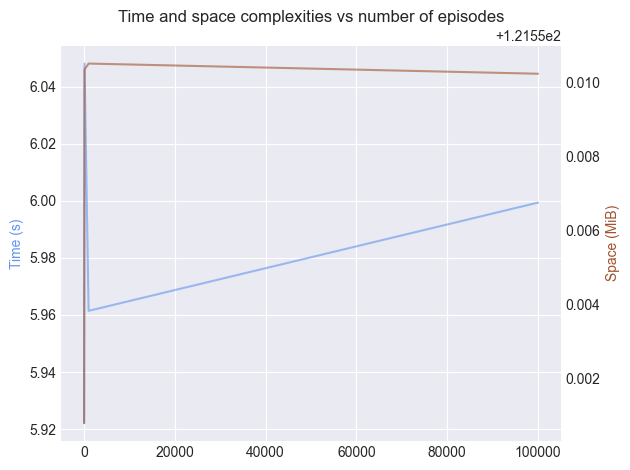

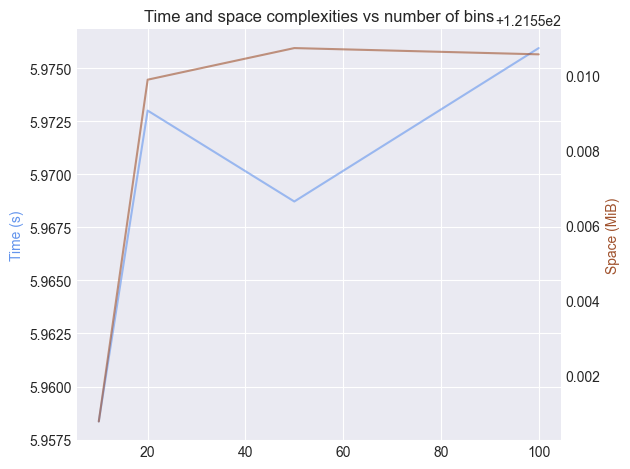

In [10]:
# Get results
performance_evaluator.get_all_performance_evaluations()

### 7. Documentation

The documentation API was constructed using the "sphinx" documentation generator. The following showcases the basic flow for automatically updating and accessing the sphinx docs.

Note: If the file structure changes, or if additional information is required, please refer to the Docs section of the project README.

To run any of the sphinx commands, make sure sphinx and sphinx-rtd-theme are pip installed in the interpreter.

#### Updating the documentation

In [11]:
# Go to documentation folder
os.chdir("documentation")

# Automatically update the documentation
! make html

# Go back to repository root
os.chdir("..")

Running Sphinx v5.0.2
loading pickled environment... done
building [mo]: targets for 0 po files that are out of date
building [html]: targets for 0 source files that are out of date
updating environment: 0 added, 0 changed, 0 removed
looking for now-outdated files... none found
no targets are out of date.
build succeeded.

The HTML pages are in _build/html.


#### Accessing the documentation

In [12]:
# Go to the html sub-folder of the documentation
os.chdir("documentation/_build/html")

# Open the documentation at the index page
! open index.html

# Go back to repository root
os.chdir("../../..")